# Introduction

This notebook presents **bag-of-words** sentiment anlysis on [IMDB](http://ai.stanford.edu/~amaas/data/sentiment/) movie reviews dataset.

**Contents**

* [IMDB Dataset](#IMDB-Dataset) - load and preprocess
* [Preprocess Data](#Preprocess-Data) - cleanup and reduce noise
* [PyTorch Model](#Keras-Model) - build and train model

# Imports

In [1]:
import os
import re
import collections
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

Pick GPU if available

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# IMDB Dataset

Download the dataset from [here](http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz) and extract. Point path below to extracted location.

In [3]:
dataset_location = '/home/marcin/Datasets/imdb'

Helper to load the dataset

In [4]:
def load_imdb_dataset(dataset_loc):
    def read_reviews(path, label, reviews, labels):
        files_list = sorted(os.listdir(path))
        for filename in sorted(os.listdir(path)):
            with open(os.path.join(path, filename)) as f:
                reviews.append(f.read())
                labels.append(label)
        return reviews, labels
    
    path_train_pos = os.path.join(dataset_location, 'aclImdb_v1/aclImdb/train/pos')
    path_train_neg = os.path.join(dataset_location, 'aclImdb_v1/aclImdb/train/neg')
    path_test_pos = os.path.join(dataset_location, 'aclImdb_v1/aclImdb/test/pos')
    path_test_neg = os.path.join(dataset_location, 'aclImdb_v1/aclImdb/test/neg')
    
    train_revs, train_labels = [], []
    train_revs, train_labels = read_reviews(path_train_pos, 1, train_revs, train_labels)
    train_revs, train_labels = read_reviews(path_train_neg, 0, train_revs, train_labels)
    
    test_revs, test_labels = [], []
    test_revs, test_labels = read_reviews(path_test_pos, 1, test_revs, test_labels)
    test_revs, test_labels = read_reviews(path_test_neg, 0, test_revs, test_labels)
    
    return (train_revs, train_labels), (test_revs, test_labels)

Load dataset

In [5]:
train_data, test_data = load_imdb_dataset(dataset_location)
train_reviews_raw, train_labels_raw = train_data
test_reviews_raw, test_labels_raw = test_data   

**Look at the Data**

Lets see a sample review

In [6]:
print(train_reviews_raw[0])

Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High's satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I'm here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn't!


Count words in the dataset

In [7]:
def count_words(list_of_examples):
    if isinstance(list_of_examples[0], str):
        split = True  # got list of strings, need to split words
    if isinstance(list_of_examples[0], list):
        split = False  # list of lists, already split by words
    
    words_counter = collections.Counter()
    for example in list_of_examples:
        if split:
            words_counter.update(example.split())
        else:
            words_counter.update(example)
            
    total_words = sum(list(words_counter.values()))
    unique_words = len(words_counter)
    
    return total_words, unique_words, words_counter

In [8]:
total_words, unique_words, words_counter = count_words(train_reviews_raw)
print('Total words: ', total_words)
print('Unique words: ', unique_words)

Total words:  5844680
Unique words:  280617


We have 5.8M words (as separated by spaces) and 280k unique words

And lets have a look at word count distributions


In [9]:
def plot_counts(words_counter, title):
    sorted_all = np.array(sorted(list(words_counter.values()), reverse=True))
    fig, [ax1, ax2] = plt.subplots(1, 2, figsize=[16,6])
    ax1.plot(sorted_all); ax1.set_title(title + ' Counts (linear scale)')
    ax2.plot(sorted_all); ax2.set_title(title + ' Counts (log scale)')
    ax2.set_yscale('log')

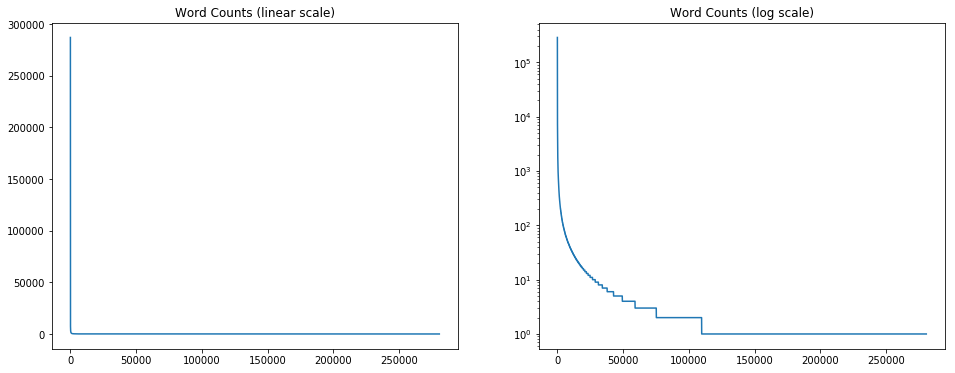

In [10]:
plot_counts(words_counter, title='Word')

Some words appear 300k times (left plot), while there is over 150k "words" that appear only once (right plot)

# Preprocess Data

We are going to perform following pre-processing steps:

* text cleanup - convert to lowercase and remove any non __a-z__ characters
* remove stopwords - remove words like 'the', 'a', 'an' and so on
* reduce vocabulary - keep 1000 most common words (same as tf.keras.datasets.imbd)
* tokenize - convert words to ints

**Text Cleanup**

We are going to perform following pre-processing steps:

* convert to lowercase
* keep only a-z characters, convert everything else to space
  * (we could spell digits, i.e. convert 20 to 'two zero' but we won't bother here)
* split whatever is left thus removing any consequent spaces
  
This will leave us with dataset build of 26 letters.

Note that words like "didn't" will be converted to "didn t", but that's ok. Words "did" and "didn" will still be encoded as different characters. Word "t" can be dropped when removing stopwords.

<div class="alert alert-info">

NOTE: Sometimes keeping apostrophe in regex helps

</div>

In [11]:
def text_cleanup(list_of_texts):
    """Perform text cleanup, reduce to a-z and space."""
    def cleanup(text):
        res = text.lower()
        res = regex.sub(' ', res)
        return res.split()
    
    result_cleaned = []
    regex = re.compile('[^a-z ]+')    # removes anything that is not a-z, alternative: '[^a-z\' ]+'
    for text in list_of_texts:
        result_cleaned.append(cleanup(text))
    return result_cleaned                     # doubly nested list of words

In [12]:
train_reviews = text_cleanup(train_reviews_raw)
test_reviews = text_cleanup(test_reviews_raw)
print(train_reviews[0])

['bromwell', 'high', 'is', 'a', 'cartoon', 'comedy', 'it', 'ran', 'at', 'the', 'same', 'time', 'as', 'some', 'other', 'programs', 'about', 'school', 'life', 'such', 'as', 'teachers', 'my', 'years', 'in', 'the', 'teaching', 'profession', 'lead', 'me', 'to', 'believe', 'that', 'bromwell', 'high', 's', 'satire', 'is', 'much', 'closer', 'to', 'reality', 'than', 'is', 'teachers', 'the', 'scramble', 'to', 'survive', 'financially', 'the', 'insightful', 'students', 'who', 'can', 'see', 'right', 'through', 'their', 'pathetic', 'teachers', 'pomp', 'the', 'pettiness', 'of', 'the', 'whole', 'situation', 'all', 'remind', 'me', 'of', 'the', 'schools', 'i', 'knew', 'and', 'their', 'students', 'when', 'i', 'saw', 'the', 'episode', 'in', 'which', 'a', 'student', 'repeatedly', 'tried', 'to', 'burn', 'down', 'the', 'school', 'i', 'immediately', 'recalled', 'at', 'high', 'a', 'classic', 'line', 'inspector', 'i', 'm', 'here', 'to', 'sack', 'one', 'of', 'your', 'teachers', 'student', 'welcome', 'to', 'bromw

Lets see how it looks like now

In [13]:
total_words, unique_words, words_counter = count_words(train_reviews)
print('Total words: ', total_words)
print('Unique words: ', unique_words)

Total words:  6023662
Unique words:  73272


**Remove Stopwords**

<div class="alert alert-info">

NOTE: This step doesn't provide much improvement on this task

</div>

Check most common words, they don't contribute to overall meaning of sentences

In [14]:
display(words_counter.most_common()[:10])

[('the', 336758),
 ('and', 164143),
 ('a', 163174),
 ('of', 145867),
 ('to', 135724),
 ('is', 107337),
 ('br', 101872),
 ('it', 96472),
 ('in', 93981),
 ('i', 87702)]

List of stopwords from NLTK

In [15]:
# import nltk
# nltk.download('stopwords')
# en_stopwords = nltk.corpus.stopwords.words('english')
# stopwords = {sw for sw in en_stopwords}
# print(stopwords)
stopwords = {'down', 'then', 'of', 'but', 'only', 'yours', 'himself', 'again',
             'very', 'or', 'once', 'until', 'have', "doesn't", 'what', 'during',
             "that'll", 'some', 'was', 'be', 'he', "should've", 'between',
             "shouldn't", 'further', 'no', 'yourself', 'm', 've', "you'll",
             'ain', 't', 'our', 'his', 'o', 'wouldn', 'below', 'any', 'under',
             'you', 'isn', 'theirs', 'why', 'that', 'mightn', 'ourselves', 'on',
             'haven', 'while', 'to', 'than', 'your', 'she', 'is', 'just',
             "mightn't", 'with', "you've", 'mustn', 'needn', 'same', 'me',
             'such', 'myself', 'there', 'own', 'this', 're', 'ma', 'from',
             'did', 'couldn', 'hasn', 'for', 'won', "won't", "mustn't", 'her',
             'can', 'doesn', "wouldn't", 'when', "you're", 'who', 'which', 'll',
             'itself', 'against', 'out', 'up', "it's", 'a', 'here', 'being',
             'they', 'as', 'didn', 'weren', 'aren', 'herself', 'the', 'if',
             "didn't", 'should', 'doing', 'other', 'has', 'so', "you'd",
             'above', 'do', 'before', 'at', 'had', 'each', "aren't", 'their',
             'now', 'an', 'through', 'how', 'those', 'nor', "hasn't", 'over',
             'by', 'into', 'themselves', 'most', 'shan', 'been', "she's",
             "haven't", "isn't", "wasn't", 'where', 'about', 'in', "hadn't",
             'because', 'too', 'whom', 'ours', 'him', 'yourselves', 'after',
             'and', 'were', 'both', 'will', 'it', 'my', 'few', 'having', 'them',
             'hadn', 'shouldn', 'does', 's', "couldn't", 'y', 'all', 'don',
             'off', 'more', 'am', 'd', 'hers', 'its', 'are', "shan't",
             "weren't", 'we', "needn't", 'i', 'these', "don't", 'wasn', 'not'}

In [16]:
stopwords.add('br')  # <br /> tag in a lot of reviews

Remove stopwords

In [17]:
def remove_stopwords(list_of_examples, stopwords):
    result_no_stop = []
    for list_of_words in list_of_examples:
        result_no_stop.append( [w for w in list_of_words if w not in stopwords])
    return result_no_stop

In [18]:
train_reviews_no_stop = remove_stopwords(train_reviews, stopwords)
test_reviews_no_stop = remove_stopwords(test_reviews, stopwords)

Show sample review

In [19]:
print(train_reviews_no_stop[0])

['bromwell', 'high', 'cartoon', 'comedy', 'ran', 'time', 'programs', 'school', 'life', 'teachers', 'years', 'teaching', 'profession', 'lead', 'believe', 'bromwell', 'high', 'satire', 'much', 'closer', 'reality', 'teachers', 'scramble', 'survive', 'financially', 'insightful', 'students', 'see', 'right', 'pathetic', 'teachers', 'pomp', 'pettiness', 'whole', 'situation', 'remind', 'schools', 'knew', 'students', 'saw', 'episode', 'student', 'repeatedly', 'tried', 'burn', 'school', 'immediately', 'recalled', 'high', 'classic', 'line', 'inspector', 'sack', 'one', 'teachers', 'student', 'welcome', 'bromwell', 'high', 'expect', 'many', 'adults', 'age', 'think', 'bromwell', 'high', 'far', 'fetched', 'pity']


And word counts

In [20]:
total_words, unique_words, words_counter = count_words(train_reviews_no_stop)
print('Total words: ', total_words)
print('Unique words: ', unique_words)

Total words:  2988387
Unique words:  73118


**Reduce Vocabulary**

Likewise, check most rare words. They also don't provide much meaning (what is "lagomorph" anyways?)

In [21]:
display(words_counter.most_common()[-10:])

[('lagomorph', 1),
 ('ziller', 1),
 ('deamon', 1),
 ('yaks', 1),
 ('hoodies', 1),
 ('insulation', 1),
 ('mwuhahahaa', 1),
 ('bellwood', 1),
 ('pressurized', 1),
 ('whelk', 1)]

We will reduce vocabulary to 998 words plus &lt;PAD&gt; and &lt;UNK&gt; tokens for total of 1000 words

In [22]:
def get_most_common_words(list_of_examples, num_words):
    words_ctr = collections.Counter()
    for example in list_of_examples:
        words_ctr.update(example)
    
    keep_words = {w for w, n in words_ctr.most_common()[:num_words]}
    return keep_words

In [23]:
allowed_words = get_most_common_words(train_reviews_no_stop, 9998)

Print some of the allowed words

In [24]:
print([w for w in allowed_words][:20])

['mafia', 'depth', 'franchise', 'spending', 'countryside', 'sweeping', 'vision', 'jumping', 'swiss', 'duvall', 'ballet', 'foot', 'invited', 'solving', 'air', 'mo', 'wrapped', 'justice', 'concert', 'lastly']


And reduce vocabulary

In [25]:
def reduce_vocabulary(list_of_examples, allowed_words, unk_tok='<UNK>'):
    result_reduced = []
    for example in list_of_examples:
        result_reduced.append( [w if w in allowed_words else unk_tok for w in example] )
    return result_reduced

In [26]:
train_reviews_reduced = reduce_vocabulary(train_reviews_no_stop, allowed_words)
test_reviews_reduced = reduce_vocabulary(test_reviews_no_stop, allowed_words)

Show example after reduction

In [27]:
print(train_reviews_reduced[0])

['<UNK>', 'high', 'cartoon', 'comedy', 'ran', 'time', 'programs', 'school', 'life', 'teachers', 'years', 'teaching', 'profession', 'lead', 'believe', '<UNK>', 'high', 'satire', 'much', 'closer', 'reality', 'teachers', '<UNK>', 'survive', '<UNK>', 'insightful', 'students', 'see', 'right', 'pathetic', 'teachers', '<UNK>', '<UNK>', 'whole', 'situation', 'remind', 'schools', 'knew', 'students', 'saw', 'episode', 'student', 'repeatedly', 'tried', 'burn', 'school', 'immediately', '<UNK>', 'high', 'classic', 'line', 'inspector', 'sack', 'one', 'teachers', 'student', 'welcome', '<UNK>', 'high', 'expect', 'many', 'adults', 'age', 'think', '<UNK>', 'high', 'far', 'fetched', 'pity']


And count words

In [28]:
total_words, unique_words, words_counter = count_words(train_reviews_reduced)
print('Total words: ', total_words)
print('Unique words: ', unique_words)

Total words:  2988387
Unique words:  9999


**Create dictionaries**

Technically we don't do any padding in this notebook but I'm leaving "&lt;PAD&gt;" in anyway

In [29]:
i2w = {i : w for i, (w, c) in enumerate(words_counter.most_common(), 1)}
w2i = {w : i for i, w in i2w.items()}
i2w[0] = '<PAD>'                       # use zero index for padding
w2i[i2w[0]] = 0
print('Number of words in dictionaries:', len(i2w))

Number of words in dictionaries: 10000


And confirm dictionaries are build correctly

In [30]:
for i in range(10):
    word = i2w[i]
    print(i, ':', word, ':', w2i[word])

0 : <PAD> : 0
1 : <UNK> : 1
2 : movie : 2
3 : film : 3
4 : one : 4
5 : like : 5
6 : good : 6
7 : time : 7
8 : even : 8
9 : would : 9


Print subset of vocabulary

In [31]:
print(sorted(list(i2w.values()))[:100])

['<PAD>', '<UNK>', 'aaron', 'abandon', 'abandoned', 'abbott', 'abc', 'abducted', 'abilities', 'ability', 'able', 'aboard', 'abominable', 'abomination', 'abortion', 'abound', 'abraham', 'abroad', 'abrupt', 'abruptly', 'absence', 'absent', 'absolute', 'absolutely', 'absorbed', 'absorbing', 'abstract', 'absurd', 'absurdity', 'abu', 'abundance', 'abuse', 'abused', 'abusive', 'abysmal', 'academic', 'academy', 'accent', 'accents', 'accept', 'acceptable', 'acceptance', 'accepted', 'accepting', 'accepts', 'access', 'accessible', 'accident', 'accidental', 'accidentally', 'acclaim', 'acclaimed', 'accompanied', 'accompany', 'accompanying', 'accomplish', 'accomplished', 'accomplishment', 'according', 'account', 'accounts', 'accuracy', 'accurate', 'accurately', 'accused', 'ace', 'achieve', 'achieved', 'achievement', 'achievements', 'achieves', 'achieving', 'acid', 'acknowledge', 'acknowledged', 'acquire', 'acquired', 'across', 'act', 'acted', 'acting', 'action', 'actions', 'active', 'activities', '

**Tokenize**

Convert words into integer tokens

In [32]:
def tokenize(list_of_examples, word2idx):
    result_tokenized = []
    for list_of_words in list_of_examples:
        result_tokenized.append( [word2idx[w] for w in list_of_words] )
    return result_tokenized

In [33]:
train_reviews_tok = tokenize(train_reviews_reduced, w2i)
test_reviews_tok = tokenize(test_reviews_reduced, w2i)

Show example

In [34]:
print(train_reviews_tok[0])

[1, 194, 916, 102, 1994, 7, 5643, 264, 34, 5050, 59, 4829, 5707, 354, 148, 1, 194, 1839, 14, 2254, 486, 5050, 1, 1844, 1, 5644, 1363, 12, 99, 1067, 5050, 1, 1, 115, 752, 2848, 5645, 559, 1363, 110, 265, 1275, 3544, 653, 3344, 264, 1080, 1, 194, 233, 225, 2771, 7543, 4, 5050, 1275, 2185, 1, 194, 404, 33, 1314, 418, 26, 1, 194, 120, 4001, 2072]


**Trimming and Padding**

Lets have a look at review lengths next

In [36]:
lengths = np.array([len(r) for r in train_reviews_tok])
lenghts_counter = collections.Counter(lengths)

In [37]:
print('Shortest review:', lengths.min())
print('Longest review: ', lengths.max())

Shortest review: 4
Longest review:  1422


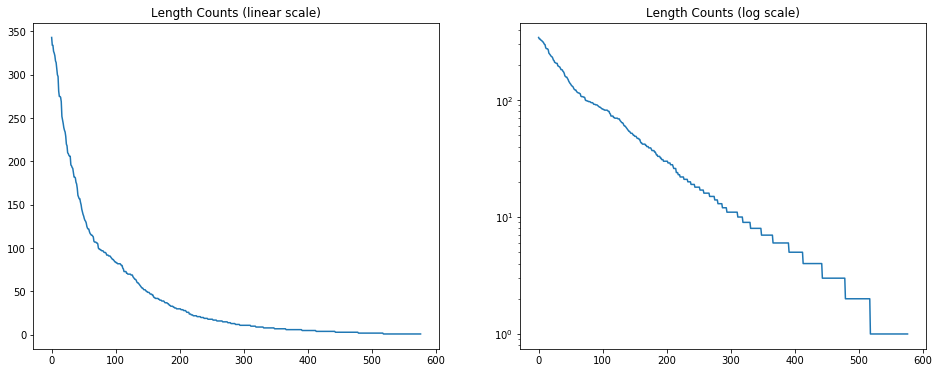

In [38]:
plot_counts(lenghts_counter, title='Length')

Lets see how many reviews are over 200 words long

In [39]:
num_over_200 = (lengths > 200).sum()
precentage_over_200 = 100*num_over_200 / len(lengths)
print('Num over 200:        ', num_over_200)
print('Precentage over 200: ', round(precentage_over_200, 2))

Num over 200:         3541
Precentage over 200:  14.16


To feed reviews into neural network in mini-batches all reviews have to have same length.

We will:
* trim all reviews to 200 words
* pad all shorter reviews with &lt;NOP&gt;

In [42]:
def trim_and_pad(list_of_examples, target_len, dtype):
    result_np = np.zeros(shape=(len(list_of_examples), target_len), dtype=dtype)
    
    for i in range(len(list_of_examples)):
        example_trimmed = list_of_examples[i][:target_len]      # trim
        start = target_len - len(example_trimmed)
        result_np[i, start:target_len] = example_trimmed
        
    return result_np

At 10k words in the vocabulary we will fit in the int16 type

In [43]:
target_type = np.int16
assert len(i2w) < np.iinfo(target_type).max
train_reviews_np = trim_and_pad(train_reviews_tok, target_len=200, dtype=target_type)
test_reviews_np = trim_and_pad(test_reviews_tok, target_len=200, dtype=target_type)

In [45]:
print(train_reviews_np)

[[   0    0    0 ...  120 4001 2072]
 [   1    1  578 ...    1  161  166]
 [   0    0    0 ...   12   78  276]
 ...
 [   0    0    0 ...   15    2   16]
 [   0    0    0 ...    1 1043  650]
 [   0    0    0 ...  311    7 1194]]


In [46]:
print(train_reviews_np[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    1  194  916  102 1994    7 5643  264   34
 5050   59 4829 5707  354  148    1  194 1839   14 2254  486 5050    1
 1844    1 5644 1363   12   99 1067 5050    1    1  115  752 2848 5645
  559 1363  110  265 1275 3544  653 3344  264 1080    1  194  233  225
 2771 7543    4 5050 1275 2185    1  194  404   33 1314  418   26    1
  194 

In [47]:
' '.join(i2w[c] for c in train_reviews_np[0] if c != 0)

'<UNK> high cartoon comedy ran time programs school life teachers years teaching profession lead believe <UNK> high satire much closer reality teachers <UNK> survive <UNK> insightful students see right pathetic teachers <UNK> <UNK> whole situation remind schools knew students saw episode student repeatedly tried burn school immediately <UNK> high classic line inspector sack one teachers student welcome <UNK> high expect many adults age think <UNK> high far fetched pity'

**Convert Labels**

In [48]:
train_labels = np.array(train_labels_raw).reshape(-1, 1)
test_labels = np.array(test_labels_raw).reshape(-1, 1)

In [49]:
print(train_labels)

[[1]
 [1]
 [1]
 ...
 [0]
 [0]
 [0]]


# PyTorch Model

Helper function for accuracy

In [44]:
def accuracy(pred, tar): 
    return (pred == tar).float().mean()  # tensor!!

Model with one hidden, one output layer

In [45]:
model = nn.Sequential(
    nn.Linear(in_features=10000, out_features=50),
    nn.Sigmoid(),
    nn.Linear(in_features=50, out_features=1))    # no sigmoid at the output
model.to(device)
criterion = nn.BCEWithLogitsLoss()                # because this expects logits
optimizer = torch.optim.Adam(model.parameters())
print(model)

Sequential(
  (0): Linear(in_features=10000, out_features=50, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=50, out_features=1, bias=True)
)


Convert dataset to tensors

In [46]:
train_features = torch.tensor(train_reviews_enc, dtype=torch.float32, device=device)
train_targets = torch.tensor(train_labels, dtype=torch.float32, device=device)
test_features = torch.tensor(test_reviews_enc, dtype=torch.float32, device=device)
test_targets = torch.tensor(test_labels, dtype=torch.float32, device=device)

Train model

In [47]:
batch_size = 250
hist = { 'loss':[], 'acc':[] }

model.train()

for epoch in range(2):  # loop over the dataset multiple times
    indices = torch.randperm(len(train_features), device=device)
    for i in range(0, len(train_features), batch_size):
    
        # Pick mini-batch
        inputs = train_features[indices[i:i+batch_size]]
        targets = train_targets[indices[i:i+batch_size]]
        
        # Optimize
        optimizer.zero_grad()
        logits = model(inputs)
        loss = criterion(logits, targets)
        loss.backward()
        optimizer.step()
        
        # Record
        with torch.no_grad():
            probabilities = torch.sigmoid(logits)
            predictions = probabilities.round()
            acc = accuracy(predictions, targets)
            hist['loss'].append( loss.item() )
            hist['acc'].append( acc.item() )

Final results

In [48]:
model.eval()                                                       # set model for evaluatiotn, disable dropout etc
with torch.no_grad():
    outputs = model(train_features)
    probabilities = torch.sigmoid(outputs)
    predictions = probabilities.data.round()
    acc = accuracy(predictions, train_targets).item() 
print(f'Accuracy on train set: {acc:.2f}')

Accuracy on train set: 0.92


In [49]:
model.eval()                                                       # set model for evaluatiotn, disable dropout etc
with torch.no_grad():
    outputs = model(test_features)
    probabilities = torch.sigmoid(outputs)
    predictions = probabilities.data.round()
    acc = accuracy(predictions, test_targets).item() 
print(f'Accuracy on test set: {acc:.2f}')

Accuracy on test set: 0.88


Plot loss and accuracy over training period

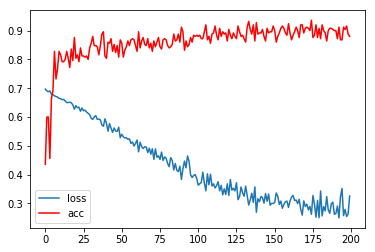

In [50]:
plt.plot(hist['loss'], label='loss')
plt.plot(hist['acc'], label='acc', color='red')
plt.legend();